Used to check for instances where CV copilot should have picked/placed a block by being within 2.54cm of the goal but did not do so.

In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
from bci_plot.gen_data.robot import process_logs
from bci_plot.metadata import robot_sessions
from bci_plot.metadata import robot_random

In [41]:
def plot_circle(ax, center, radius, n=41, **kwargs):
    pts = np.stack([center[0] + radius*np.cos(2*np.pi/(n-1)*np.arange(n)), center[1] + radius*np.sin(2*np.pi/(n-1)*np.arange(n))], axis=1)
    circ = ax.plot(*pts.T, **kwargs)
    return circ

In [203]:
session = 'exp_2024-03-18_12-59-19'
blocks = [
    'exp_2024-03-18_12-12-21.log', # passthrough, pick/place twice, test with arrow keys
    'exp_2024-03-18_12-21-46.log', # passthrough, pick/place once, test.
    'exp_2024-03-18_12-25-04.log', # passthrough, failed grip at the end 
    'exp_2024-03-18_12-32-04.log', # passthrough, short, no pick/place
    'exp_2024-03-18_12-34-06.log', # passthrough, 6 pick/place, not affected by bug. not complete ~~
    'exp_2024-03-18_12-44-36.log', # passthrough, 5 pick/place, affected by max_goal bug ~~
    'exp_2024-03-18_12-54-00.log', # non-passthrough, 2 picks, 1 place. not affected by bug
    'exp_2024-03-18_13-00-03.log', # passthrough, first half is affected by bug, best sequence ~200000 and on.   ~~ fiest half actually maybe not affected
]

resample_info = {
     'exp_2024-03-18_12-12-21.log': [(7707, 72063)], # test with arrow keys
     'exp_2024-03-18_12-21-46.log': [(228, 6630)], # test
     'exp_2024-03-18_12-25-04.log': [(27359, 97966)], # not complete
     'exp_2024-03-18_12-32-04.log': [],
     'exp_2024-03-18_12-34-06.log': [(26824, 228608)],# not affected. not complete.
     'exp_2024-03-18_12-44-36.log': [(23827, 184486)], # affected by another bug (max_goal inconsistency bug)
     'exp_2024-03-18_12-54-00.log': [(27083, 138402)], # not affected by bug, not complete.
     'exp_2024-03-18_13-00-03.log': [
         (24707, 153714), # affected by bug (would have placed first block at original location), complete?
         (206799, 314381), # not affected, complete
     ],
 }

In [ ]:
logs_all = {}
for block in blocks:
    logs = process_logs.process_logs(f'/data/raspy/robot/{session}/robot_logs/{block}') # passthrough
    logs_all[block] = logs

exp_2024-03-18_12-34-06.log 12
exp_2024-03-18_12-44-36.log 10
exp_2024-03-18_12-54-00.log 3
exp_2024-03-18_13-00-03.log 18


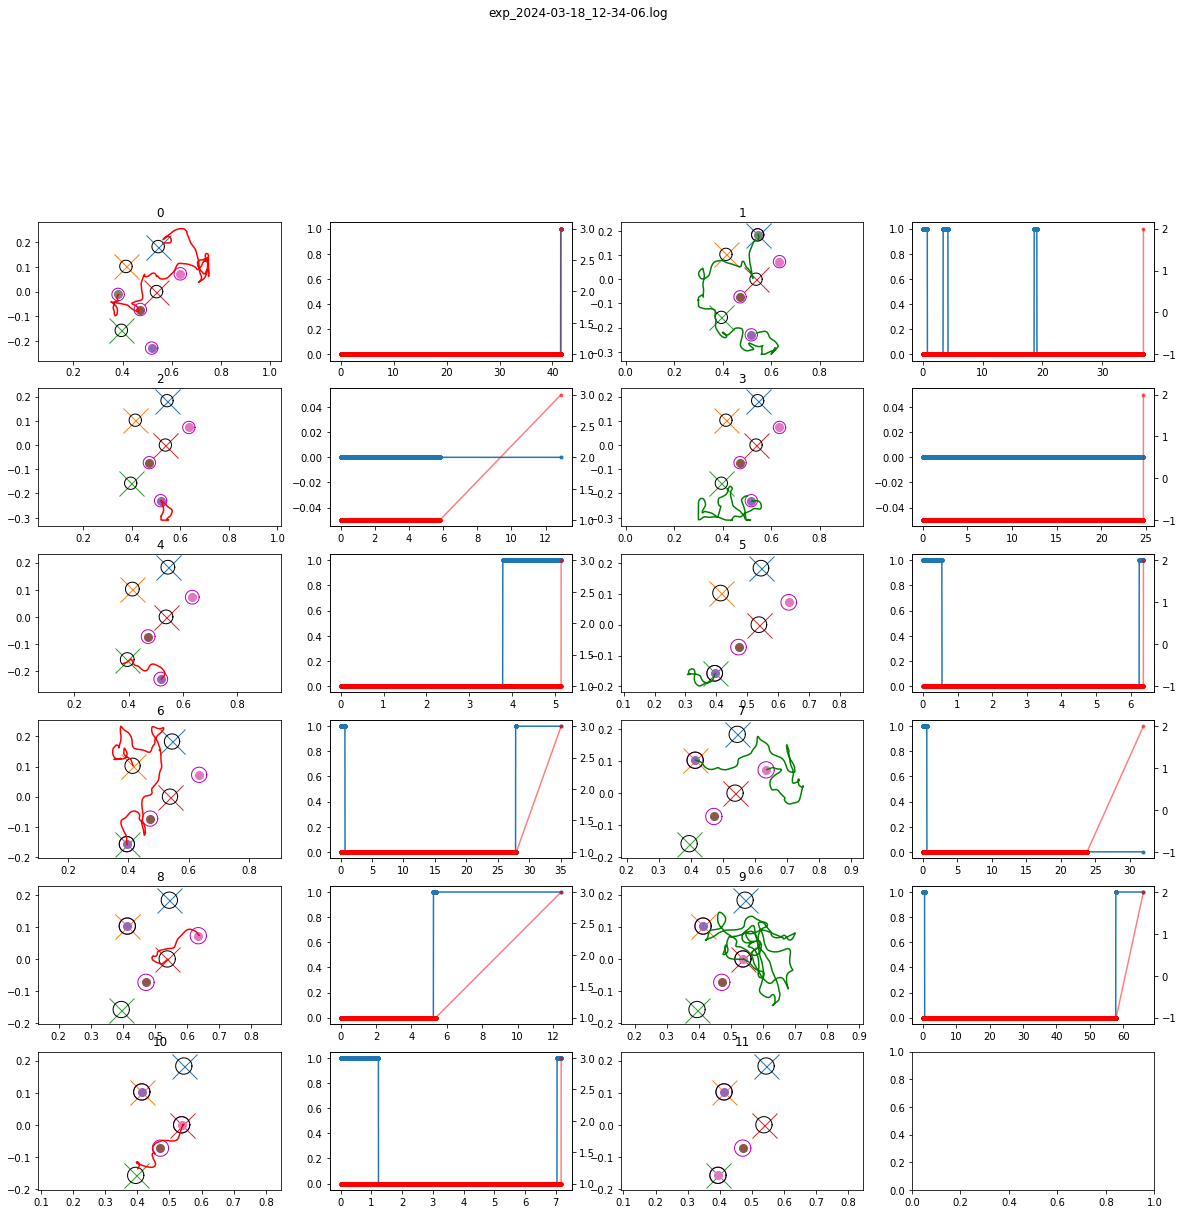

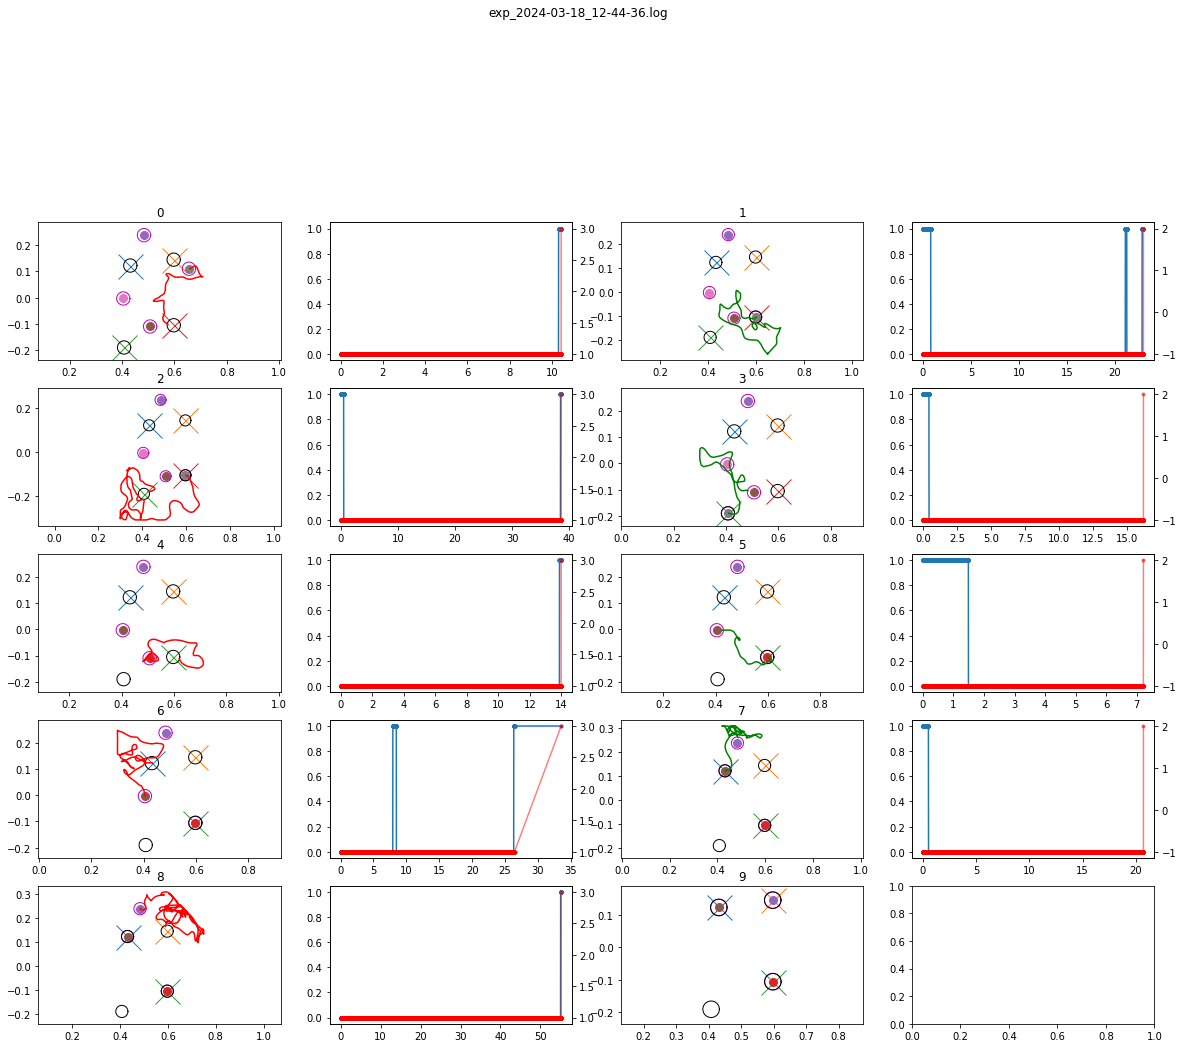

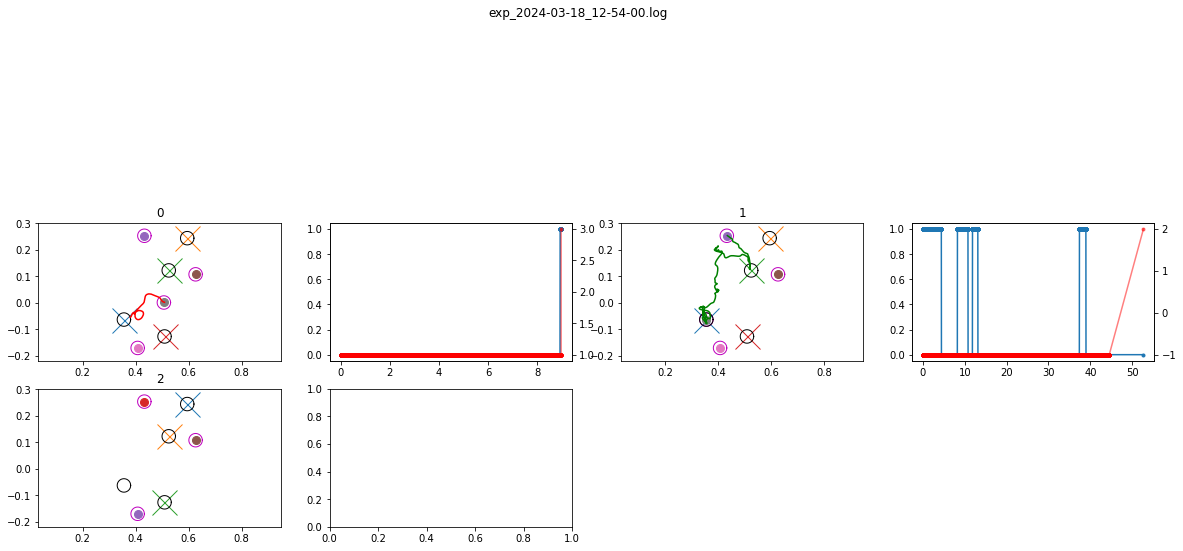

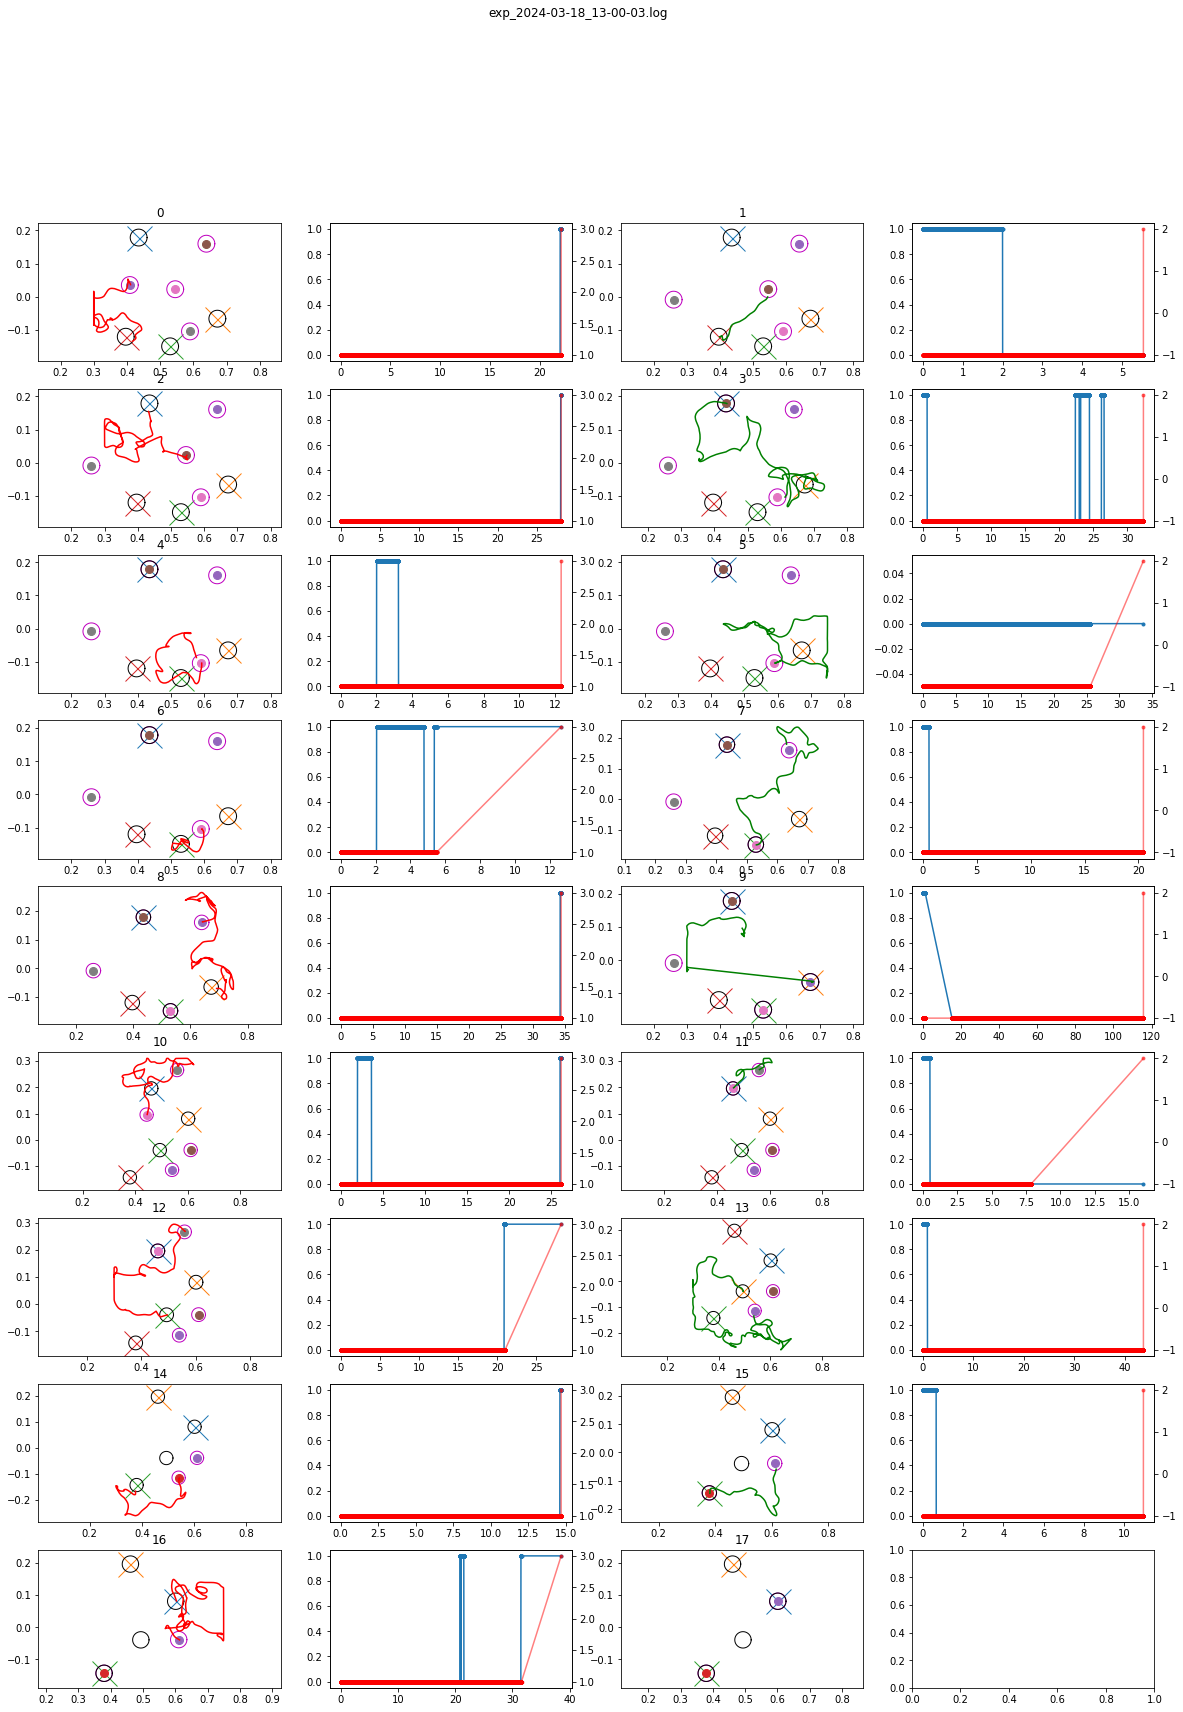

In [101]:
for m in [4, 5, 6, 7]:
    logs = logs_all[blocks[m]]

    action_idxs = np.nonzero(np.isin(logs['gripper'], [2, 3]))[0] + 1
    obj_idxs = np.digitize(action_idxs, logs['all_objs_idx']) - 1

    plt.figure(figsize=(20, 30))
    original_ids = logs['all_objs_ids'][obj_idxs[0]]
    original_locs = logs['all_objs_list'][obj_idxs[0]]
    original_bin_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='bin'])
    original_block_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='obj'])
    
    print(blocks[m], len(obj_idxs))

    for i, idx in enumerate(obj_idxs):
        if blocks[m] == 'exp_2024-03-18_13-00-03.log' and i >= 10:
            original_ids = logs['all_objs_ids'][obj_idxs[10]]
            original_locs = logs['all_objs_list'][obj_idxs[10]]
            original_bin_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='bin'])
            original_block_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='obj'])
        plt.subplot(10, 4, 2*i+1)
        ids = logs['all_objs_ids'][idx]
        locs = logs['all_objs_list'][idx]
        bin_locs = np.array([loc for loc, o_id in zip(locs, ids) if o_id[0] =='bin'])
        block_locs = np.array([loc for loc, o_id in zip(locs, ids) if o_id[0] =='obj'])
        for loc in bin_locs:
            plt.plot(*loc, 'x', ms=25)
        for loc in block_locs:
            plt.plot(*loc, '.', ms=16)
            plot_circle(plt.gca(), loc, 0.0254, color='m', lw=1)
        for loc in original_bin_locs:
            plot_circle(plt.gca(), loc, 0.0254, color='k', lw=1)

        try:
            s = action_idxs[i]
            e = action_idxs[i+1]
            c = 'g' if logs['gripper'][s+1] == -1 else 'r'
            plt.plot(*logs['xyz'][s:e, 0:2].T, color=c)
        except:
            pass
        plt.title(i)
        plt.axis('equal')
        
        plt.subplot(10, 4, 2*i+2)
        try:
            dmin = np.linalg.norm(logs['xyz'][s:e, 0:2][:, None, :] - original_bin_locs[None, :, :], axis=-1).min(-1)
            tt = logs['timestamp'][s:e]
            tt = tt - tt[0]
            plt.plot(tt, dmin < 0.0254, '.-')
            plt.gca().twinx()
            plt.plot(tt, logs['gripper'][s:e], 'r.-', alpha=0.5)
        except:
            pass
        
    plt.suptitle(blocks[m])

In [178]:
def resample_objs(logs, trial_starts_ends=()):
    # resample the obj info for trials with bugged CV.
    objs_list = []
    objs_ids = []
    objs_idx = []
    
    # For compatibility to prevent indexing errors due to digitize operation
    objs_list.append(logs['all_objs_list'][0])
    objs_ids.append(logs['all_objs_ids'][0])
    objs_idx.append(logs['all_objs_idx'][0])
    
    for trial_start, trial_end in trial_starts_ends:
        original_objs_idx = np.digitize(trial_start, logs['all_objs_idx']) - 1
        original_objs = logs['all_objs_list'][original_objs_idx]
        original_ids = logs['all_objs_ids'][original_objs_idx]
        
        objs_list.append(original_objs.copy())
        objs_ids.append(original_ids.copy())
        objs_idx.append(trial_start)
        
        current_objs = original_objs.copy()
        current_ids = original_ids.copy()
         # these should not change
        block_idxs = np.nonzero([o_id[0] == 'obj' for o_id in current_ids])[0] # these should not change
        bin_idxs = np.nonzero([o_id[0] == 'bin' for o_id in current_ids])[0] # these should not change
        
        gripper_idxs = trial_start + np.nonzero(np.isin(logs['gripper'][trial_start:trial_end], [2, 3]))[0]
        
        gs = -1
        for idx in gripper_idxs:
            if logs['gripper'][idx] == 2:
                xy = logs['xyz'][idx, 0:2]
                closest_block_idx_idx = np.argmin(np.linalg.norm(current_objs[block_idxs] - xy, axis=-1))
                current_block_idx = block_idxs[closest_block_idx_idx]
                current_ids[current_block_idx] = ['obj', 'picked']
                
                bin_dists = np.linalg.norm(current_objs[bin_idxs] - current_objs[current_block_idx], axis=-1)
                if np.min(bin_dists) < 0.001:
                    # pick from bin
                    closest_bin_idx_idx = np.argmin(bin_dists)
                    current_bin_idx = bin_idxs[closest_bin_idx_idx]
                    current_ids[current_bin_idx] = ['bin', 'empty']
                    pass
                pass
            elif logs['gripper'][idx] == 3:
                xy = logs['xyz'][idx, 0:2]
                dists = np.linalg.norm(current_objs[bin_idxs] - xy, axis=-1)
                if np.min(dists) < 0.0254:
                    # place at an empty bin
                    closest_bin_idx_idx = np.argmin(dists)
                    current_bin_idx = bin_idxs[closest_bin_idx_idx]
                    current_ids[current_bin_idx] = ['bin', 'full']
                    
                    current_ids[current_block_idx] = ['obj', 'placed']
                    current_objs[current_block_idx] = current_objs[current_bin_idx]
                else:
                    # replace at original location
                    current_ids[current_block_idx] = ['obj', 'placed']
                    pass
                pass
            else:
                print('?')
            
            objs_list.append(current_objs.copy())
            objs_ids.append(current_ids.copy())
            objs_idx.append(idx)
            pass
        
    return objs_list, objs_ids, objs_idx

In [206]:
for block, logs in logs_all.items():
    objs_list, objs_ids, objs_idx = resample_objs(logs, resample_info[block])
    logs['all_objs_list'], logs['all_objs_ids'], logs['all_objs_idx'] = objs_list, objs_ids, objs_idx

exp_2024-03-18_12-34-06.log 12
exp_2024-03-18_12-34-06.log 0 [41.53932428]
exp_2024-03-18_12-34-06.log 0 [8.02183938]
exp_2024-03-18_12-34-06.log 1 [ 3.37069154 18.60539246]
exp_2024-03-18_12-34-06.log 1 [36.79524136]
exp_2024-03-18_12-34-06.log 2 []
exp_2024-03-18_12-34-06.log 2 [5.68362284]
exp_2024-03-18_12-34-06.log 3 []
exp_2024-03-18_12-34-06.log 3 [24.66846538]
exp_2024-03-18_12-34-06.log 4 [3.77575183]
exp_2024-03-18_12-34-06.log 4 []
exp_2024-03-18_12-34-06.log 5 [6.24282122]
exp_2024-03-18_12-34-06.log 5 [6.24282122]
exp_2024-03-18_12-34-06.log 6 [27.81632996]
exp_2024-03-18_12-34-06.log 6 [6.13868189]
exp_2024-03-18_12-34-06.log 7 []
exp_2024-03-18_12-34-06.log 7 [23.64549971]
exp_2024-03-18_12-34-06.log 8 [5.24073458]
exp_2024-03-18_12-34-06.log 8 []
exp_2024-03-18_12-34-06.log 9 [57.76404738]
exp_2024-03-18_12-34-06.log 9 [57.76404738]
exp_2024-03-18_12-34-06.log 10 [7.0387969]
exp_2024-03-18_12-34-06.log 10 [2.58967686]
exp_2024-03-18_12-44-36.log 10
exp_2024-03-18_12-44-

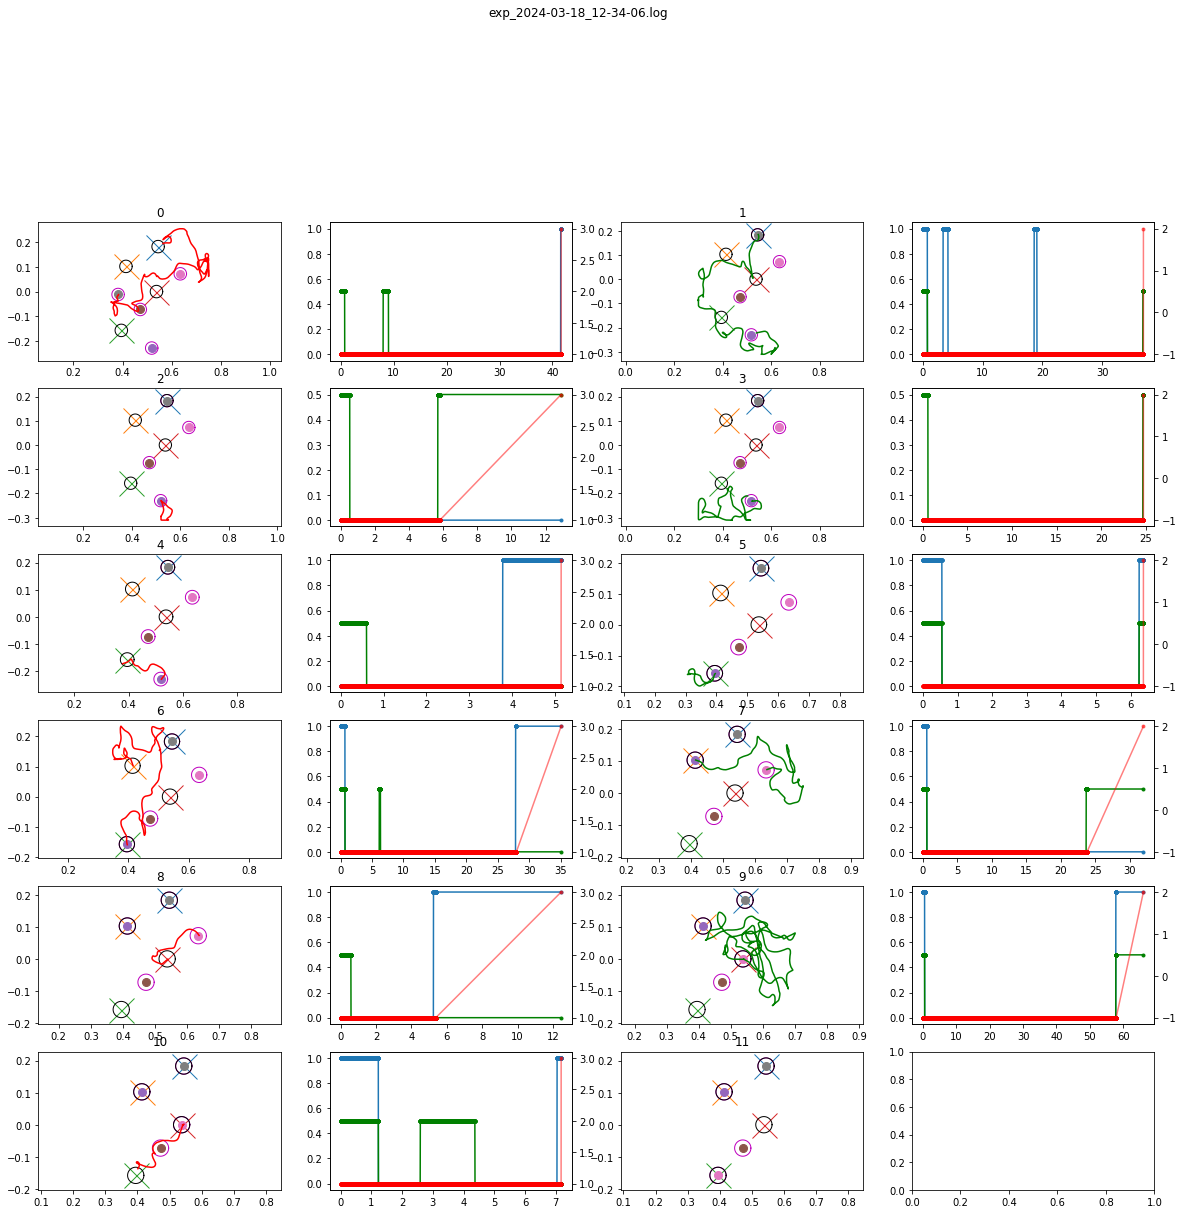

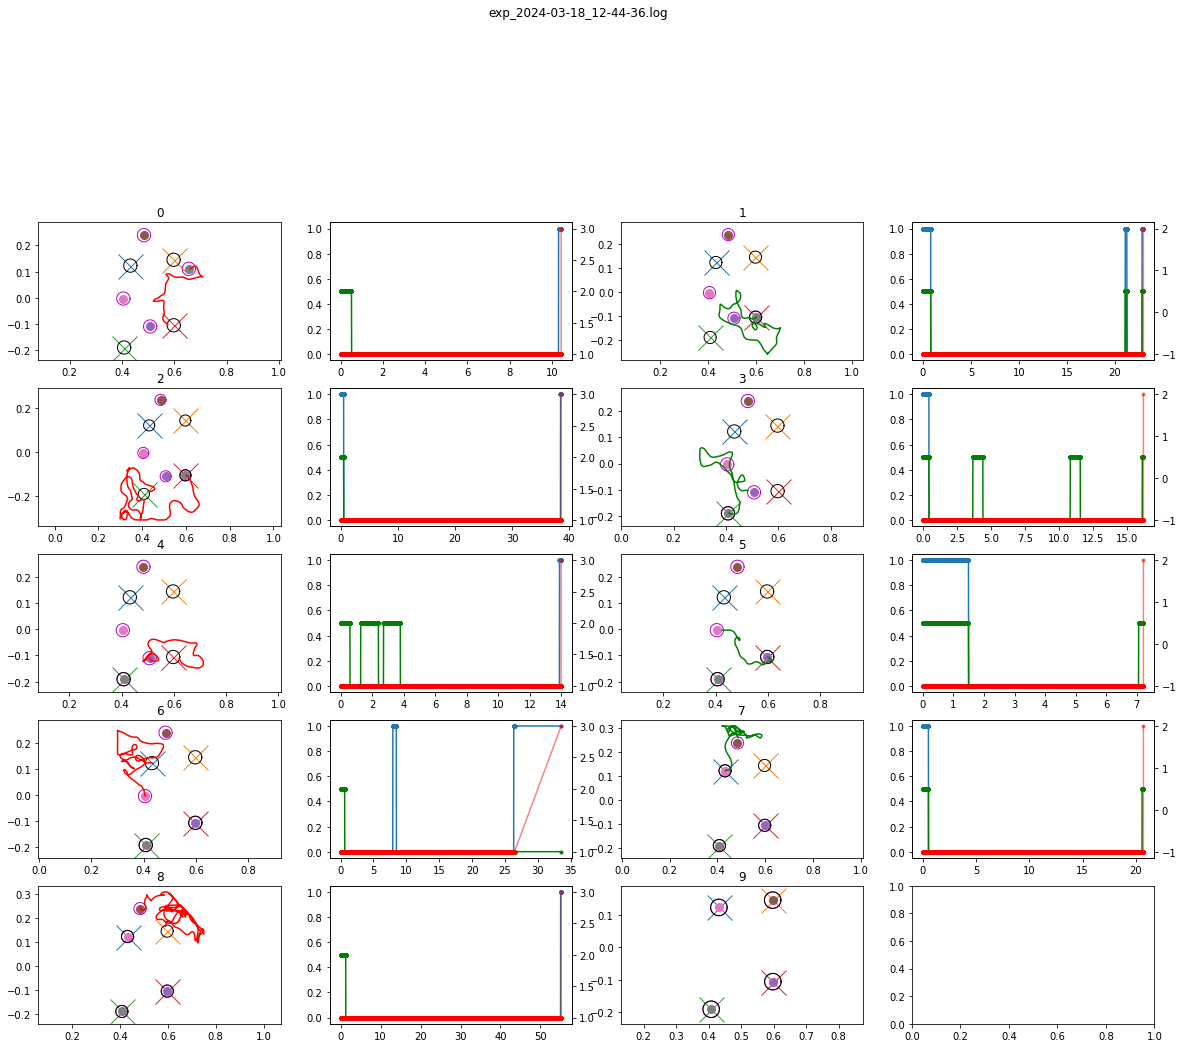

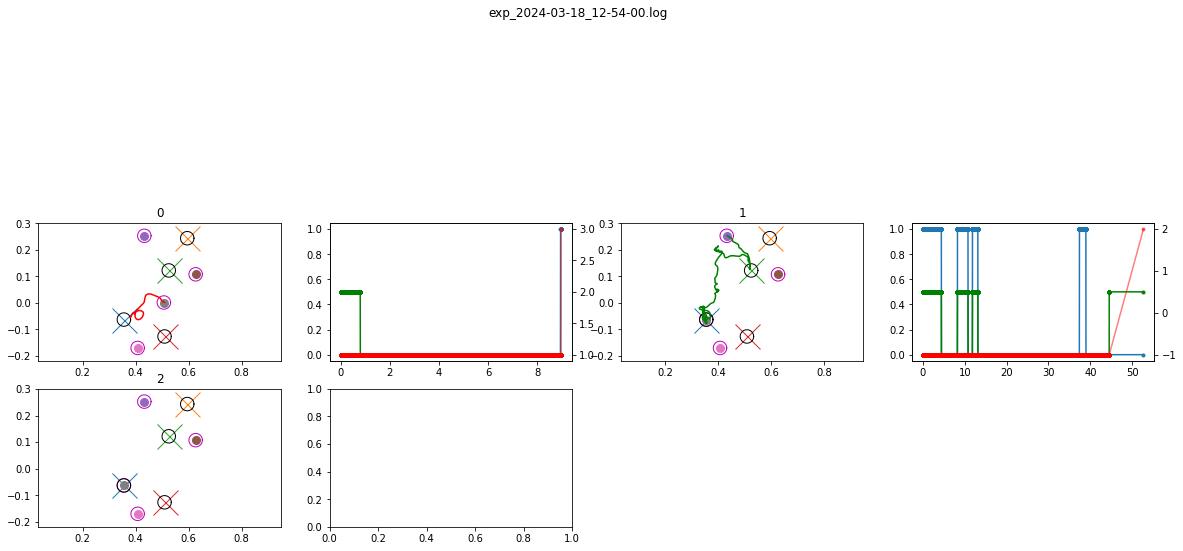

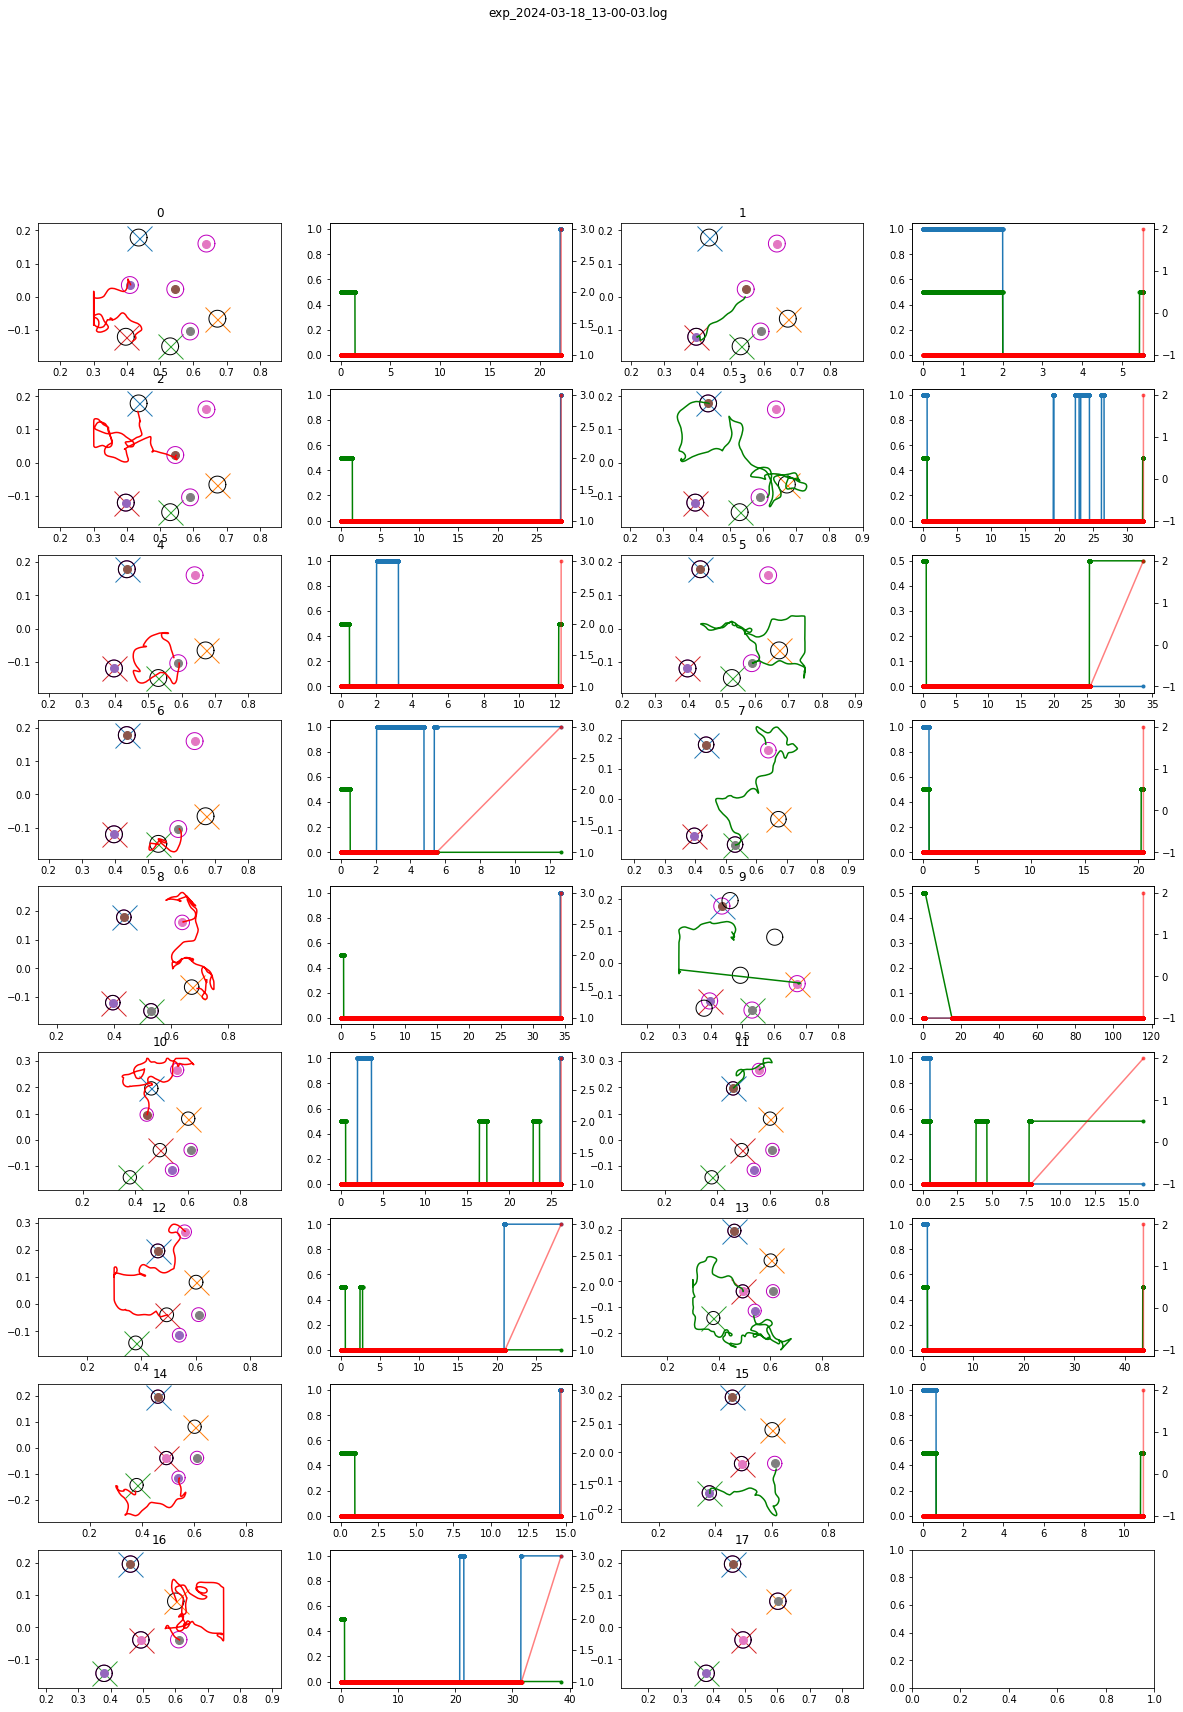

In [224]:
for m in [4, 5, 6, 7]:
    logs = logs_all[blocks[m]]

    action_idxs = np.nonzero(np.isin(logs['gripper'], [2, 3]))[0] + 1
    obj_idxs = np.digitize(action_idxs, logs['all_objs_idx']) - 1

    plt.figure(figsize=(20, 30))
    original_ids = logs['all_objs_ids'][obj_idxs[0]]
    original_locs = logs['all_objs_list'][obj_idxs[0]]
    original_bin_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='bin'])
    original_block_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='obj'])
    
    print(blocks[m], len(obj_idxs))

    for i, idx in enumerate(obj_idxs):
        if blocks[m] == 'exp_2024-03-18_13-00-03.log' and i >= 9:
            original_ids = logs['all_objs_ids'][obj_idxs[10]]
            original_locs = logs['all_objs_list'][obj_idxs[10]]
            original_bin_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='bin'])
            original_block_locs = np.array([loc for loc, o_id in zip(original_locs, original_ids) if o_id[0] =='obj'])
        plt.subplot(10, 4, 2*i+1)
        ids = logs['all_objs_ids'][idx]
        locs = logs['all_objs_list'][idx]
        bin_locs = np.array([loc for loc, o_id in zip(locs, ids) if o_id[0] =='bin'])
        block_locs = np.array([loc for loc, o_id in zip(locs, ids) if o_id[0] =='obj'])
        for loc in bin_locs:
            plt.plot(*loc, 'x', ms=25)
        for loc in block_locs:
            plt.plot(*loc, '.', ms=16)
            plot_circle(plt.gca(), loc, 0.0254, color='m', lw=1)
        for loc in original_bin_locs:
            plot_circle(plt.gca(), loc, 0.0254, color='k', lw=1)

        try:
            s = action_idxs[i]
            e = action_idxs[i+1]
            c = 'g' if logs['gripper'][s+1] == -1 else 'r'
            plt.plot(*logs['xyz'][s:e, 0:2].T, color=c)
        except:
            pass
        plt.title(i)
        plt.axis('equal')
        
        plt.subplot(10, 4, 2*i+2)
        try:
            dmin = np.linalg.norm(logs['xyz'][s:e, 0:2][:, None, :] - original_bin_locs[None, :, :], axis=-1).min(-1)
            tt = logs['timestamp'][s:e]
            tt = tt - tt[0]
            d_within_radius = dmin < 0.0254
            plt.plot(tt, d_within_radius, '.-')
            print(blocks[m], i, tt[np.nonzero((d_within_radius[1:None] == 1)*(d_within_radius[0:-1] == 0))[0] + 1])
            
            # by block
            dmin = np.linalg.norm(logs['xyz'][s:e, 0:2][:, None, :] - block_locs[None, :, :], axis=-1).min(-1)
            d_within_radius = dmin < 0.0254
            plt.plot(tt, 0.5*d_within_radius, 'g.-')
            
            print(blocks[m], i, tt[np.nonzero((d_within_radius[1:None] == 1)*(d_within_radius[0:-1] == 0))[0] + 1])
            plt.gca().twinx()
            plt.plot(tt, logs['gripper'][s:e], 'r.-', alpha=0.5)
        except Exception as e:
            pass
        
    plt.suptitle(blocks[m])

In [ ]:
# max goal inconsistency potential time saves:
# exp_2024-03-18_12-44-36.log 6 [ 7.92854261 26.31626177] -> 18.38771916
# exp_2024-03-18_13-00-03.log 16 [20.80040216 31.47636294] -> 10.67596078
# exp_2024-03-18_12-44-36.log 3 [ 3.6657877  10.81477141 16.10048652] -> 5.28571511. ended up picking up the wrong block despite passing over correct block

In [225]:
26.31626177 - 7.92854261, 31.47636294 - 20.80040216, 16.10048652 - 10.81477141

(18.38771916, 10.67596078, 5.28571511)